# Invader Defender 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pickle
from scipy.optimize import linprog
import pandas as pd
import time
import random

# to remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
actions = [[-1, 0], [0, 1], [1, 0], [0, -1]] #up, right, down, left = (clockwise from up) 
action_count = len(actions) 
gridSize = 6 
state_count = gridSize*gridSize

In [3]:
class Invader_Defender():
    def __init__(self, gridSize):
        self.valueMap = np.zeros((gridSize, gridSize))
        self.states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
        self.size = gridSize
        
        # deterministic transition ?
        self.transition_prob = 1 
        
        # initialize defender and invader states
        self.new_state = [0, 0, 0, 0]
        self.new_defender_state = [0, 0]
        self.new_invader_state = [0, 0]
        
        # set territory state
        self.territory_state = [4, 4]

        # create a list of all possible states in the game
        self.game_state_list = []
        for defender_state in self.states:
            for invader_state in self.states:
                combined_states = tuple(defender_state + invader_state)
                self.game_state_list.append(combined_states)
        
        # create 2 lists of states representing defender and invader victory
        self.defender_won = []
        self.invader_won = []
        
        # create states representing defender victory
        for defender_state in self.states:
            for invader_state in self.states:
                distance = np.linalg.norm(np.array(defender_state) - np.array(invader_state))
                # if the invader is not at territory and within the capture range of defender = defender won
                if invader_state != self.territory_state and distance <= np.sqrt(2):
                    combined_states = defender_state + invader_state
                    self.defender_won.append(combined_states)
           
        # create states representing invader victory = anytime invader is at territory
        for defender_state in self.states:               
            combined_states = defender_state + self.territory_state
            self.invader_won.append(combined_states)
    
    def possible_states(self):
        """
        A function that returns a list of all possible states in the game
        """
        return self.game_state_list
    
    def terminal_check(self, state):
        """
        A function that checks whether the game is at a terminal state.
        Terminal state happens when either the invader or defender has won.
        """
        if state in self.defender_won:
            status = "Defender Won"
            terminal_check = True
        elif state in self.invader_won:
            status = "Invader Won"
            terminal_check = True
        else:
            terminal_check = False
            status = "Game in Progress"

        return terminal_check, status
    
#     def transition_probability(self, transition):
#         """
#         A function that returns the transition probability...?
#         """
#         return self.transition_prob, reward

    def next_state(self, current_state, defender_action, invader_action):
        """
        A function that returns the next state
        Input: current state [0,0] , defender_action [0, 1], invader_action [0,-1]
        Output: next state array([x1,y1,x2,y2]) and reward (int)
            - If the action takes the agent off grid, the agent remains in original state
            - If defender won, reward is calculated based on manhattan distance between invader captured state
            and territory
            - If defender loss, reward is -100
        """
        defender_state = []
        invader_state = []
        
        # deconstruct current state [0,0,1,1] in to defender [0,0] and invader [1,1] state
        for i in range(4):
            if i < 2:
                defender_state.append(current_state[i])
            else:
                invader_state.append(current_state[i])
                
        # get next state: state: [0, 0], action: [0, 1], new_state = [0, 1]
        self.new_defender_state = list(np.array(defender_state) + np.array(defender_action))
        self.new_invader_state = list(np.array(invader_state) + np.array(invader_action))

        # if new defender states results in off the grid, return to original state
        if -1 in self.new_defender_state or self.size in self.new_defender_state:
            self.new_defender_state = defender_state
        
        # if new invader states results in off the grid, return to original state
        if -1 in self.new_invader_state or self.size in self.new_invader_state:
            self.new_invader_state = invader_state
       
        # combine the defender and invader state
        self.new_state = self.new_defender_state
        self.new_state.extend(self.new_invader_state)
                  
        # new rewards: penalizing defender for every step that invader takes closer to territory
        terminal, status = self.terminal_check(self.new_state)
        if terminal == True:
            if status == "Defender Won":
                # defender reward if defender won (manhattan distance between invader captured state and territory)
                distance_to_territory = sum(abs(np.array(self.new_invader_state) - np.array(self.territory_state)))
                self.reward = distance_to_territory
            else:
                # defender reward if invader won
                self.reward = -1000
        else:
            # penalize defender for every step that invader takes closer to territory
            invader_to_territory = sum(abs(np.array(self.new_invader_state) - np.array(self.territory_state)))
            reward_1 = -(8*10 - invader_to_territory*10)
          
            # # give defender reward for every step it takes closer to invader
            # new_defender_state = [self.new_defender_state[0], self.new_defender_state[1]]
            # defender_to_invader = sum(abs(np.array(self.new_invader_state) - np.array(new_defender_state)))
            # reward_2 = (5 - defender_to_invader)
            
            # self.reward = reward_1 + reward_2
            self.reward = reward_1
            
#             self.reward = reward_1
            
        return self.new_state, self.reward

## Initialization and Function Definitions

In [4]:
invader_defender = Invader_Defender(6)

In [5]:
state_list = []
delta_list = []

In [6]:
def calculate_value(G_state):
    """
    A function that calculates the value of a game by using linear programming.
    The value is calculated in both the defender and invader's perspective which are equal in value
    and opposite in signs
    Input: payoff matrix of a particular state (4x4 matrix)
    Output: Value = scalar value of the game.
    """
    
    G_state = list(G_state)
    
    # defender lin prog
    c = [0, 0, 0, 0, -1]
    defender_q = -1*np.transpose(G_state)     
    v_coeff = np.ones((4,1))
    Aub = np.concatenate((defender_q,v_coeff),1)
    b = [0, 0, 0, 0]
    Aeq = [[1, 1, 1, 1, 0]]
    beq = [[1.]]
    bounds = ((0,1),(0,1),(0,1),(0,1),(None, None))
    defender_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='revised simplex')
    
    # invader lin prog
    c = [0, 0, 0, 0, 1]
    invader_q = G_state
    w_coeff = np.ones((4,1))*-1
    Aub = np.concatenate((invader_q,w_coeff),1)
    invader_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='revised simplex')
    
    # check if the linprog solution is successful or not
    if defender_solution['status'] == 0:
        value = defender_solution['fun']*-1
    else:
        value = invader_solution['fun']
    
#     print("defender value: ", defender_solution['fun'])
#     print("invader value: ", invader_solution['fun'])
    
    return value

In [7]:
def calculate_payoff(state):
    """
    A function calculates the payoff of a specific state based on Q values
    Input: state (ie. [0,0,1,1])
    Output: payoff = 4x4 matrix where each element represent the defender's payoff 
    when defender take i, and invader take action j
    """
    state = list(state)
    payoff = np.zeros([4,4])
    for i in range(action_count):
        defender_action = i
        for j in range(action_count):
            invader_action = j
            joint_action = [defender_action, invader_action]
            state_action_pair = tuple(state + joint_action)
            payoff[i, j] = Q[state_action_pair]

    return payoff

In [8]:
def equilibrium(G_state):
    """
    A function that obtains the policy for defender and invader
    The value is calculated in both the defender and invader's perspective which are equal in value
    and opposite in signs
    Input: payoff matrix of a particular state (4x4 matrix)
    Output: policy for defender and invader
    """
    
    # defender lin prog
    c = [0, 0, 0, 0, -1]
    defender_q = -1*np.transpose(G_state)     
    v_coeff = np.ones((4,1))
    Aub = np.concatenate((defender_q,v_coeff),1)
    b = [0, 0, 0, 0]
    Aeq = [[1, 1, 1, 1, 0]]
    beq = [[1.]]
    bounds = ((0,1),(0,1),(0,1),(0,1),(None, None))
    defender_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='revised simplex')
    
    # invader lin prog
    c = [0, 0, 0, 0, 1]
    invader_q = G_state
    w_coeff = np.ones((4,1))*-1
    Aub = np.concatenate((invader_q,w_coeff),1)
    invader_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='revised simplex')
    
    if defender_solution['status'] == 0:
        defender_policy = defender_solution['x'][:4]
    else:
        defender_policy = np.array([0.25,0.25,0.25,0.25])
    
    if invader_solution['status'] == 0:
        invader_policy = invader_solution['x'][:4]
    else:
        invader_policy = np.array([0.25,0.25,0.25,0.25])

    return defender_policy, invader_policy

In [9]:
#NEW CHOOSE ACTION
def choose_action(defender_policy, invader_policy, epsilon):
    """
    A function that choose a joint epsilon-greedy action based on defender/invader policy
    Input: defender_policy (1x4), invader policy (1x4), and epsilon (ie. 0.3)
    Output: joint action index = [defender action index, invader action index] = [0 to 3, 0 to 3]
    """
       
    # choose an action type: explore (0) or exploit(1)
    action_type = int(np.random.choice(2, 1, p=[epsilon,1-epsilon]))
    
    if action_type == 0:
        
        # randomly pick an action
        defender_action_index = random.choice(range(4))    
        invader_action_index = random.choice(range(4))    
    
    else:
        defender_action_index = int(np.random.choice(action_count, 1, p=defender_policy.clip(0)))
        invader_action_index = int(np.random.choice(action_count, 1, p=invader_policy.clip(0)))
    
    joint_action = [defender_action_index, invader_action_index]
    
    return joint_action

In [10]:
def generate_trajectory(Defender_state, Invader_state, greedy):
    
    terminal = False
    generated = False
    exceeded = 0
    
    # while not successful generation, repeat
    while not generated:
        game_step = 0
        current_state = tuple(Defender_state + Invader_state)
        game_trajectory = []
        cumulated_reward = 0
        # generate a game trajectory
        while not terminal:
            
            generated = True
            
            # append game trajectory
            game_trajectory.append(current_state)

            # check if game is terminal (someone won)
            terminal, status = invader_defender.terminal_check(list(current_state))
            
            if greedy:
                invader_action = actions[int(np.random.choice(action_count, 1, p=invader_policy[tuple(current_state)].clip(0)))]
                defender_action = actions[int(np.random.choice(action_count, 1, p=defender_policy[tuple(current_state)].clip(0)))]
              
            else:     
                # both agents choose action based on policy via sampling
                invader_action = actions[int(np.random.choice(action_count, 1, p=invader_policy[tuple(current_state)].clip(0)))]
                defender_action = actions[int(np.random.choice(action_count, 1, p=defender_policy[tuple(current_state)].clip(0)))]

            # obtain next state
            next_state, reward = invader_defender.next_state(list(current_state), defender_action, invader_action)
            current_state = tuple(next_state)
            cumulated_reward = cumulated_reward + reward
            
            game_step += 1
#             clear_output(wait=True)
#             display("game step: " + str(game_step))
            
            # exit the game if the game steps increase pass 100 (implying agents are stuck)
            if game_step > 50:
                exceeded += 1
                generated = True     
                break
    
    return game_trajectory, status, cumulated_reward

## Minimax Q

### Initialization 

In [11]:
# initialize params
t = 0
T = 200
lr = 0.9
gamma = 0.95
epsilon = 0.99

In [12]:
# initialize Q matrix
state_action_pair_list = []

# create every possible state action pairs: 
# 1296 states * 4 defender actions * 4 invader actions = 20736 s,a pairs
for state in invader_defender.game_state_list:
    for defender_action in range(action_count):
        for invader_action in range(action_count):
            joint_action = [defender_action, invader_action]
            state_action_pair = list(state) + joint_action
            state_action_pair_list.append(tuple(state_action_pair))

In [13]:
# initialize a dictionary for Q values = {(x1, y1, x2, y2, defender_action_index, invader_action_index): q_value}
listofzeros = [0.0] * len(state_action_pair_list)
Q = dict(zip(state_action_pair_list, listofzeros))

# initialize a dictionary for G values = {(x1, y1, x2, y2): payoff_matrix}
listofzeros = [0.0] * len(invader_defender.game_state_list)
for state in invader_defender.game_state_list:
    state_list.append(state)
G = dict(zip(state_list, listofzeros))

# initialize policies
initial_policy = []
defender_policy = {}
invader_policy = {}
for i in range(len(invader_defender.game_state_list)):
    random_policy = np.array([0.25, 0.25, 0.25, 0.25])
    initial_policy.append(random_policy)
defender_policy = dict(zip(state_list, initial_policy))
invader_policy = dict(zip(state_list, initial_policy))

### Algorithm Starts 

In [14]:
# initialize states
defender_state = [5,0]
invader_state = [0,0]
current_state = tuple(defender_state + invader_state)

In [15]:
# build game based on Q value
G[current_state] = calculate_payoff(current_state)

In [16]:
# choose a policy by solving the current game
defender_policy[current_state], invader_policy[current_state] = equilibrium(G[current_state])
equilibrium(G[current_state])

(array([1., 0., 0., 0.]), array([1., 0., 0., 0.]))

In [17]:
def generate_q_dict(state):
#     Q_state_list = []
#     for state in invader_defender.game_state_list:
    Q_state = []
    for defender_action in range(action_count):
        for invader_action in range(action_count):
            state_action_pair = tuple(list(state) + [defender_action, invader_action])
            Q_state.append(Q[state_action_pair])
    
#     Q_state_list.append(Q_state)
#     Q_state_dict = dict(zip(state_list, Q_state_list))
    return max(Q_state)

In [18]:
# initialize a dictionary for G values = {(x1, y1, x2, y2): payoff_matrix}
listofzeros = [0.0] * len(state_action_pair_list)
# for state in invader_defender.game_state_list:
#     state_list.append(state)
state_count = dict(zip(state_action_pair_list, listofzeros))

In [19]:
%%time

# trajectory = []
episodes = 20000
eps = 0
unique_counter = 0
tolerance = 1
delta_list = []
delta = 2
cumulated_reward_list = []

for eps in range(episodes):
    t = 0
    delta = 0
    while t < T:
        
        # choose a joint based on epsilon greedy (joint_action = [a1_indx, a2_indx])
        joint_action = choose_action(defender_policy[current_state], invader_policy[current_state], epsilon)
        current_state_action_pair = tuple(list(current_state) + joint_action) # ie. (x1, y1, x2, y2, a1_indx, a2_indx)

        # decaying learning rate
        state_count[current_state_action_pair] += 1
        lr_ = lr / state_count[current_state_action_pair]
        
        # get next state and reward based on current state [x1,y1,x2,y2] and joint action [a1_indx, a2_indx]
        next_state, reward = invader_defender.next_state(current_state, actions[joint_action[0]], actions[joint_action[1]])
        next_state = tuple(next_state)
        
        # build a game based on next state: calculate payoff of next state
        G[next_state] = calculate_payoff(next_state)

        # generate a policy based on equilibirum of next game
        defender_policy[next_state], invader_policy[next_state] = equilibrium(G[next_state])

        # make copy of Q table
        Q_copy = Q[current_state_action_pair]

        # update Q[s,a] <- Q[s,a] + lr*(reward + gamma*value(s') - Q[s,a])
        value = calculate_value(G[next_state])
        Q[current_state_action_pair] = Q[current_state_action_pair] + lr_*(reward + gamma*value - Q[current_state_action_pair])
       
        # if game reached terminal state, restart new episode
        terminal, status = invader_defender.terminal_check(list(next_state))
        if terminal:
            defender_state = [5,0]
            invader_state = [0,0]
            current_state = tuple(defender_state + invader_state)
            break

        # calculate delta
        delta = max(delta, abs(Q[current_state_action_pair] - Q_copy))
                
        # set next state as current state
        current_state = next_state
        t+=1
    
    # Testing
    game_trajectory, status, cumulated_reward = generate_trajectory([5,0],[0,0], True) 
    cumulated_reward_list.append(cumulated_reward)
    
#     print k and current max delta
    clear_output(wait=True)
    display('episode: ' + str(eps) + ' delta: ' + str(round(delta, 3)) + ' lr: ' + str(lr_))
    delta_list.append(delta)

'episode: 19999 delta: 0.078 lr: 0.006081081081081081'

CPU times: user 57min 4s, sys: 3min 42s, total: 1h 46s
Wall time: 55min 22s


Text(0, 0.5, 'Reward')

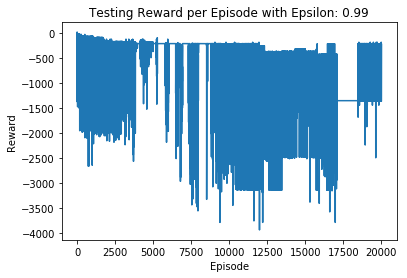

In [20]:
# reward per episode
plt.plot(cumulated_reward_list)
plt.title('Testing Reward per Episode with Epsilon: ' + str(epsilon))
plt.xlabel('Episode')
plt.ylabel('Reward')

In [21]:
# defender reward
sum_reward = 0
sum_reward_list = []
for i in range(len(cumulated_reward_list)):
    sum_reward = sum_reward + cumulated_reward_list[i]
    sum_reward_list.append(sum_reward)

Text(0, 0.5, 'Reward')

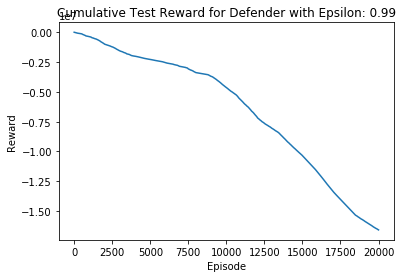

In [22]:
plt.plot(sum_reward_list)
plt.title('Cumulative Test Reward for Defender with Epsilon: ' + str(epsilon))
plt.xlabel('Episode')
plt.ylabel('Reward')

In [23]:
# invader reward
sum_reward = 0
sum_reward_list = []
for i in range(len(cumulated_reward_list)):
    sum_reward = sum_reward + (cumulated_reward_list[i]*-1)
    sum_reward_list.append(sum_reward)

Text(0, 0.5, 'Reward')

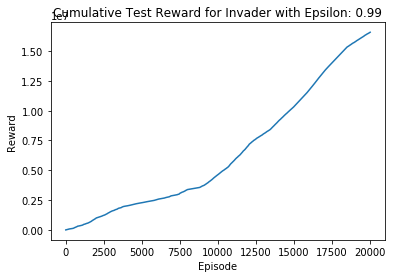

In [24]:
plt.plot(sum_reward_list)
plt.title('Cumulative Test Reward for Invader with Epsilon: ' + str(epsilon))
plt.xlabel('Episode')
plt.ylabel('Reward')

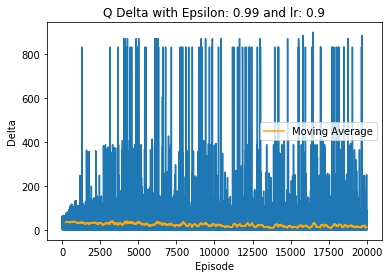

In [25]:
# Q delta
plt.plot(delta_list)
plt.title('Q Delta with Epsilon: ' + str(epsilon) + " and lr: " + str(lr))
plt.xlabel('Episode')
plt.ylabel('Delta')

# plot moving average
reward_frame = pd.DataFrame(delta_list)
rolling_mean = reward_frame.rolling(window=200).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')
plt.legend()
plt.show()

In [26]:
# policy extraction
for state in invader_defender.game_state_list:    
    G[state] = calculate_payoff(state)
    defender_policy[state], invader_policy[state] = equilibrium(G[state])

In [27]:
defender_policy[(5,0,0,0)]

array([1.00000000e+00, 3.33066907e-16, 0.00000000e+00, 0.00000000e+00])

In [28]:
invader_policy[(5,0,0,0)]

array([0., 1., 0., 0.])

In [29]:
defender_policy[(5,0,1,2)]

array([0.12242063, 0.87757937, 0.        , 0.        ])

In [30]:
invader_policy[(5,0,1,2)]

array([-5.55111512e-17,  8.63238556e-01,  1.36761444e-01,  0.00000000e+00])

In [31]:
defender_policy

{(0, 5, 5, 2): array([0.4843065, 0.       , 0.       , 0.5156935]),
 (3, 3, 5, 4): array([0.        , 0.        , 0.09501734, 0.90498266]),
 (5,
  1,
  0,
  3): array([5.55111512e-17, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 (5, 3, 5, 0): array([1., 0., 0., 0.]),
 (3, 1, 2, 0): array([1., 0., 0., 0.]),
 (0, 4, 1, 2): array([0., 0., 0., 1.]),
 (3, 3, 1, 5): array([0.2272237, 0.7727763, 0.       , 0.       ]),
 (5,
  4,
  5,
  0): array([ 7.41388155e-01,  0.00000000e+00, -2.77555756e-17,  2.58611845e-01]),
 (4, 4, 4, 1): array([0., 0., 0., 1.]),
 (0, 2, 2, 4): array([0.        , 0.43922172, 0.56077828, 0.        ]),
 (4, 3, 4, 1): array([0., 0., 0., 1.]),
 (3, 1, 2, 1): array([1., 0., 0., 0.]),
 (1,
  1,
  0,
  3): array([1.55431223e-15, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 (4, 2, 5, 4): array([0.05926623, 0.94073377, 0.        , 0.        ]),
 (0, 1, 4, 4): array([1., 0., 0., 0.]),
 (0,
  4,
  5,
  1): array([0.00000000e+00, 1.11022302e-16, 0.00000000e+00, 1.0000

### Save Results to Pickle 

In [51]:
with open('Q_minimax.pickle', 'wb') as handle:
    pickle.dump(Q, handle)

with open('G_minimax.pickle', 'wb') as handle:
    pickle.dump(G, handle)

## Load from Pickle and Extract Policy 

In [0]:
# # uncomment to load U and G
# with open ('Q_minimax.pickle', 'rb') as handle:
#     Q = pickle.load(handle)
    
# with open ('G_minimax.pickle', 'rb') as handle:
#     G = pickle.load(handle)

In [0]:
# # initialize policies
# initial_policy = []
# defender_policy = {}
# invader_policy = {}
# for i in range(len(invader_defender.game_state_list)):
#     random_policy = np.array([0.25, 0.25, 0.25, 0.25])
#     initial_policy.append(random_policy)
# defender_policy = dict(zip(state_list, initial_policy))
# invader_policy = dict(zip(state_list, initial_policy))

# # policy extraction
# for state in invader_defender.game_state_list:    
#     G[state] = calculate_payoff(state)
#     defender_policy[state], invader_policy[state] = equilibrium(G[state])

In [0]:
# defender_policy[(5,0,0,0)]

In [0]:
# invader_policy[(5,0,0,0)]

## Heatmap

In [32]:
# create Q_state_dict = {(x1,y1,x2,y2): [1,2,3....16]} where 1-16 represent the Q values 
# of each defender invader action combination

Q_state_list = []
for state in invader_defender.game_state_list:
    Q_state = []
    for defender_action in range(action_count):
        for invader_action in range(action_count):
            state_action_pair = tuple(list(state) + [defender_action, invader_action])
            Q_state.append(Q[state_action_pair])
    Q_state_list.append(Q_state)      
    
Q_state_dict = dict(zip(state_list, Q_state_list))

### Invader Map 

In [33]:
# create a list of states that fixes the defender's starting position
fixed_defender_state_list = []
for invader_state in invader_defender.states:
    fixed_defender_state = tuple([5, 0] + invader_state)
    fixed_defender_state_list.append(fixed_defender_state)

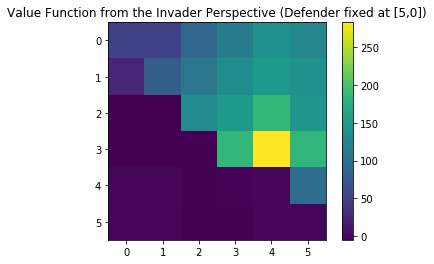

In [34]:
invader_map = np.zeros([6,6])
for state in fixed_defender_state_list:
    invader_map[state[2], state[3]] = max(Q_state_dict[state])*-1  # -1 for invaders perspective

# if the defender is fixed at the bottom left corner, this heatmap shows the invader's rewards
plt.imshow(invader_map, interpolation='nearest')
plt.colorbar()
plt.title('Value Function from the Invader Perspective (Defender fixed at [5,0])')
plt.show()

### Defender Map 

In [35]:
# create a list of states that fixes the invaders's starting position
fixed_invader_state_list = []
for defender_state in invader_defender.states:
    fixed_invader_state = tuple(defender_state + [0, 0])
    fixed_invader_state_list.append(fixed_invader_state)

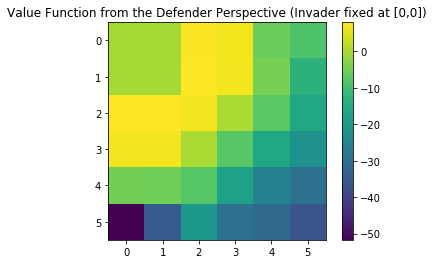

In [36]:
# create invader heatmap
defender_map = np.zeros([6,6])
for state in fixed_invader_state_list:
    defender_map[state[0], state[1]] = max(Q_state_dict[state])

# if invader is fixed at top left corner, this heatmap shows the defender's rewards
plt.imshow(defender_map, interpolation='nearest')
plt.colorbar()
plt.title('Value Function from the Defender Perspective (Invader fixed at [0,0])')
plt.show()

## Play a Game

In [37]:
# check if any element of the dictionary is negative: none
for key in defender_policy:
    if defender_policy[key].any() < 0:
        print(key)

In [38]:
# check if any element of the dictionary is negative: none
for key in invader_policy:
    if invader_policy[key].any() < 0:
        print(key)

### Animate the Game 

In [49]:
# generate game trajectory
game_trajectory, status, cumulated_reward = generate_trajectory([5,1],[0,0], False) 
status

'Defender Won'

In [50]:
# define game dimensions
columns=range(invader_defender.size)
index = range(invader_defender.size)

# animate the game
for step in range(len(game_trajectory)):
    game_table = pd.DataFrame(0, index = index, columns=columns)
    game_table[4][4] = 'Ter.'
    game_table[game_trajectory[step][1]][game_trajectory[step][0]] = 'DEF'
    game_table[game_trajectory[step][3]][game_trajectory[step][2]] = 'INV'
    clear_output(wait=True)
    display(game_table)
    time.sleep(0.2)
    
# print game status
display(status)

,0,1,2,3,4,5
0,0,0,0,0,INV,0
1,0,0,0,0,DEF,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,Ter.,0
5,0,0,0,0,0,0


'Defender Won'